## 4. Advanced Risk Management

1. Block maxima

Until now you've worked with a portfolio of four investment banks for the period 2005 - 2010. Now you'll zero in on a single asset, the stock of General Electric, for the same period and apply extreme value theory to its time series.

In this exercise, you'll examine the time series of block maxima for GE's losses over the period 2008 - 2009, using the .resample() method for three different block lengths: one week, one month, and one quarter, visualizing each series in a plot using the axis_* plot objects.

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from scipy.stats import t
from scipy import stats
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.stats import genextreme
import pandas_datareader as web

In [2]:
#  Assets to be included in the portfolio
tickers = ['GE']
portfolio = web.get_data_yahoo(tickers, start = '2007-01-01',end = '2009-12-31')
portfolio = portfolio['Adj Close']
# Ensure the prices are sorted by Date
portfolio = portfolio.sort_values(by='Date')

In [113]:
returns=portfolio.pct_change().dropna()
#we treat losses on positive scale to make our functions work properly
loss=-returns

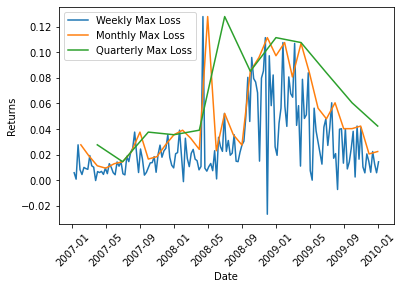

In [68]:
# Resample the data into weekly blocks
weekly_maxima = loss.resample("W").max()

# Resample the data into monthly blocks
monthly_maxima = loss.resample("M").max()

# Resample the data into quarterly blocks
quarterly_maxima = loss.resample("Q").max()

# Plot the resulting maximas
plt.plot(weekly_maxima, label = "Weekly Max Loss")
plt.plot(monthly_maxima, label = "Monthly Max Loss")
plt.plot(quarterly_maxima, label = "Quarterly Max Loss")
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

2.Extreme events during the crisis

You can use the Generalized Extreme Value (GEV) distribution to examine extreme values in the losses of General Electric (GE) during the financial crisis in 2008 and 2009.

This period coincided with GE's liquidity crisis, and its eventual requirement of an emergency investment of $3 billion from Berkshire Hathaway's Warren Buffet to stave off defaulting on its commercial paper obligations.

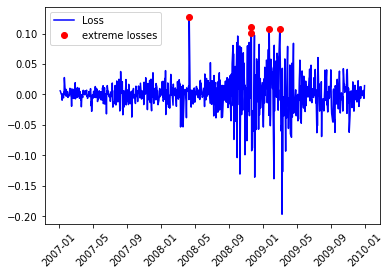

In [69]:
# Find all daily losses greater than 10%
extreme_losses = loss[loss>0.1]

# Plot the log daily losses of GE over the period 2007-2009
plt.plot(loss, label = "Loss",c='b')
plt.xticks(rotation=45)
plt.plot(extreme_losses,'r o',label = 'extreme losses')
plt.legend()
plt.show()

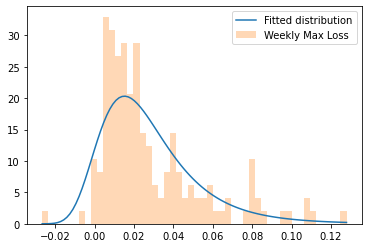

In [116]:
# Fit extreme distribution to weekly maximum of losses
data=(np.array(weekly_maxima))
fitted = genextreme.fit(data)

# Plot extreme distribution with weekly max losses historgram
x = np.linspace(min(data), max(data), 100)
plt.plot(x, genextreme.pdf(x, *fitted),label='Fitted distribution')
plt.hist(data, 50, density = True, alpha = 0.3, label = 'Weekly Max Loss')
plt.legend()
plt.show()

3. GEV risk estimation

Suppose that you were holding € 1,000,000 of GE stock on January 1, 2010. You would like to cover the expected maximum losses that might occur over the next week, based upon available data from the previous 3 years, 2007 - 2009. You assume that maximum weekly losses for GE are distributed according to a Generalized Extreme Value (GEV) distribution.

To model expected losses you'll estimate the CVaR at the 99% confidence level for the GEV distribution, and use it to compute the amount needed in reserve to cover the expected maximum weekly loss over January, 2010.

In [87]:
# Use fitted pdf fitted from previous section for GE's stock

# Compute the 99% VaR (needed for the CVaR computation)
VaR_99 = genextreme.ppf(0.99, *fitted)

# Compute the 99% CVaR estimate
CVaR_99 = (1 / (1 - 0.99)) * genextreme.expect(lambda x: x, 
           args=(fitted[0],), loc = fitted[1], scale = fitted[2], lb = VaR_99)

# Display the covering loss amount
print("Reserve amount: ", 1000000 * CVaR_99)

Reserve amount:  138762.45248556536


4. KDE of a loss distribution

Kernel density estimation (KDE) can fit distributions with 'fat tails', i.e. distributions with occasionally large deviations from the mean (such as the distribution of portfolio losses).

Student's T distribution for low degrees of freedom can also capture this feature of portfolio losses.

Compare a Gaussian KDE with a T distribution, each fitted to provided portfolio losses from 2008 - 2009. Visualize the relative fits of each using a histogram. (Recall the T distribution uses fitted parameters params, while the gaussian_kde, being non-parametric, returns a function.)

In [429]:
data=np.array(loss)
data=data.reshape(len(data))

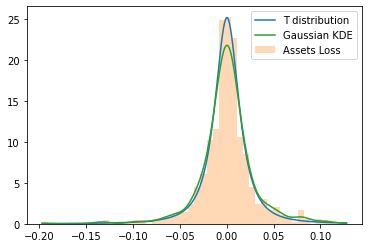

In [430]:
# Generate a fitted T distribution over losses
params = t.fit(data)

# Generate a Gaussian kernal density estimate over losses
kde = gaussian_kde(data)

# Add the PDFs of both estimates to a histogram, and display
x = np.linspace(np.min(data), np.max(data), 1000)
plt.plot(x, t.pdf(x, *params), label = 'T distribution')
plt.hist(data, 50, density = True, alpha = 0.3, label = 'Assets Loss')
plt.plot(x, kde.pdf(x), label = 'Gaussian KDE')
plt.legend(); plt.show()

5. CVaR and loss cover selection

CVaR and loss cover selection
In previous exercises you saw that both the T and the Gaussian KDE distributions fit portfolio losses for the crisis period fairly well. Given this, which of these is best for risk management? One way to choose is to select the distribution that provides the largest loss cover, to cover the "worst worst-case scenario" of losses.

The t and kde distributions are available and have been fit to 2007-2008 portfolio losses (t fitted parameters are in p). You'll derive the one day 99% CVaR estimate for each distribution; the largest CVaR estimate is then the 'safest' reserve amount to hold, covering expected losses that exceed the 99% VaR.

In [439]:
from scipy import integrate

# Find the VaR as a quantile of random samples from the distributions
VaR_99_T   = np.quantile(t.rvs(size=1000, *params), 0.99)
VaR_99_KDE = np.quantile(kde.resample(size=1000), 0.99)

In [443]:
#Lets apply integration for kde gaussian kde function
def cvar_integ_func(kde, x1, quant):

    def f_kde(x):
        return x*kde(x)

    cvar = (1 / (1 - quant))*integrate.quad(f_kde, x1, np.inf)[0]

    return cvar

In [444]:
# Find the expected tail losses, with lower bounds given by the VaR measures
integral_T = t.expect(lambda x: x, args = (params[0],), loc = params[1], scale = params[2], lb = VaR_99_T)

In [445]:
# Create the 99% CVaR estimates
CVaR_99_T   = (1 / (1 - 0.99)) * integral_T
#CVaR_99_KDE = (1 / (1 - 0.99)) * integral_KDE
CVaR_99_KDE = cvar_integ_func(kde, VaR_99_KDE, 0.99)

# Display the results
print("99% CVaR for T: ", CVaR_99_T, "; 99% CVaR for KDE: ", CVaR_99_KDE)

99% CVaR for T:  0.1872263569194183 ; 99% CVaR for KDE:  0.11573020657912134


6. Single layer neural networks

To become comfortable using neural networks it will be helpful to start with a simple approximation of a function.

You'll train a neural network to approximate a mapping between an input, x, and an output, y. They are related by the square root function, i.e. .

The input vector x is given to you. You'll first compute the square root of x using Numpy's sqrt() function, generating the output series y. Then you'll create a simple neural network and train the network on the x series.

After training, you'll then plot both the y series and the output of the neural network, to see how closely the network approximates the square root function.

In [449]:
from keras.models import Sequential
from keras.layers import Dense

In [453]:
x = np.linspace(0, 10, 1000)

# Create the training values from the square root function
y = np.sqrt(x)

# Create the neural network
model = Sequential()
model.add(Dense(16, input_dim=1, activation='relu'))
model.add(Dense(1))

# Train the network
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(x, y, epochs=100)


Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 7.6713
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 4.7382
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 2.7859
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 1.5475
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 0.7768
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 0.3176
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1165
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0724
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0590
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0469
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0363
Epoch 12/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 13/100
32/32 [=================

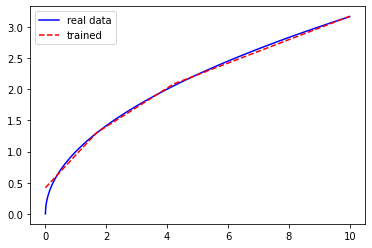

In [455]:
## Plot the resulting approximation and the training values
plt.plot(x, y, 'b-', label ='real data')
plt.plot(x, model.predict(x),'r--',label ='trained')
plt.legend()
plt.show()

7. Asset price prediction

Now you can use a neural network to predict an asset price, which is a large component of quantitative financial analysis as well as risk management.

You'll use the 2005-2010 stock prices of Citibank, Goldman Sachs and J. P. Morgan to train a network to predict the price of Morgan Stanley's stock.

You'll create and train a neural network with one input layer, one output layer and two hidden layers.

Then a scatter plot will be shown to see how far the predicted Morgan Stanley prices are from their actual values over 2005-2010. (Recall that if the predictions are perfect, the resulting scatter plot will lie on the 45-degree line of the plot.)

In [457]:
#  Assets to be included in the portfolio
tickers = ['C','GS','JPM','MS']
portfolio_b = web.get_data_yahoo(tickers, start = '2007-01-01',end = '2009-12-31')
portfolio_b = portfolio_b['Adj Close']
# Ensure the prices are sorted by Date
portfolio_b = portfolio_b.sort_values(by='Date')
prices=portfolio_b.pct_change().dropna()

In [467]:
# Set the input and output data
training_input = prices.drop('MS', axis=1)
training_output = prices['MS']

# Create and train the neural network with two  hidden layers
model = Sequential()
model.add(Dense(16, input_dim=3, activation='sigmoid'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop')
model.fit(training_input, training_output, epochs=100)

Epoch 1/100
24/24 [==============================] - 0s 2ms/step - loss: 0.2289
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0396
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 9.7586e-04
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 8.8073e-04
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 9.2763e-04
Epoch 10/100
24/24 [==============================] - 0s 2ms/step - loss: 8.4685e-04
Epoch 11/100
24/24 [==============================] - 0s 2ms/step - loss: 8.1244e-04
Epoch 12/100
24/24 [==============================] - 0s 2ms/step - loss: 8.0167e-04
Epoch 13/100


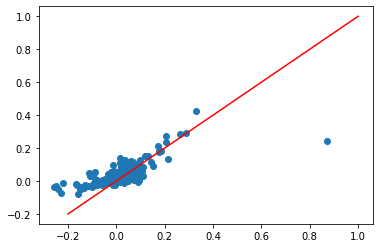

In [475]:
# Scatter plot of the resulting model prediction
plt.scatter(training_output, model.predict(training_input))
plt.plot([-0.2, 1], [-0.2, 1], c = 'r')
plt.show()

8. Real-time risk management

It's time to use what you've learned about neural networks to perform (almost!) real-time risk management.

A 14-day rolling window of asset returns provides enough data to create a time series of minimum volatility portfolios using Modern Portfolio Theory, as you saw in Chapter 2. These minimum_vol portfolio weights are the training values for a neural network. This is a (1497 x 4) matrix.

The input is the matrix of weekly average_asset_returns, corresponding to each efficient portfolio. This is a (1497 x 4) matrix.

Create a Sequential neural network with the proper input dimension and two hidden layers. Training this network would take too long, so you'll use an available pre_trained_model of identical type to predict portfolio weights for a new asset price vector.

In [476]:
# Create neural network model
model = Sequential() 
model.add(Dense(128, input_dim = 4, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))

#model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop')
#model.fit(training_input, training_output, epochs=100)

# Use the pre-trained model to predict portfolio weights given new asset returns
#asset_returns = np.array([0.001060, 0.003832, 0.000726, -0.002787])
#asset_returns.shape = (1,4)
#print("Predicted minimum volatility portfolio: ", pre_trained_model.predict(asset_returns))

Appendix: 

Test for integration of kde and t distributions

In [436]:
#Test T integral function vs t.expect
def t_func(x,a,b,c):
    a = x*t.pdf(x,a,b,c)
    return a
#integrate
I=integrate.quad(t_func, VaR_99_T,1, args=(params[0],params[1],params[2]))
print("t.pdf integral from integrate.quad:",I[0]," / From t.expect:",integral_T)

#Lets apply integration for kde gaussian kde function
def integ_func(kde, x1):

    def f_kde(x):
        return x*kde(x)

    integ = integrate.quad(f_kde, x1, np.inf)

    return integ

# Perform a kernel density estimate (KDE) on the data
kde = gaussian_kde(data)

# Define the number that will determine the integration limits
x1 = VaR_99_KDE
#conclusion
print("KDE integral from integrate.quad:",integ_func(kde, x1)[0]," / From kde.integrate:",kde.integrate_box_1d(VaR_99_KDE,1))
integral_KDE=integ_func(kde, x1)[0]

t.pdf integral from integrate.quad: 0.001725369568499933  / From t.expect: 0.001998163079490978
KDE integral from integrate.quad: 0.0010377759100956504  / From kde.integrate: 0.009685714371616432
